# Capstone Project for  Advance Data Science IBM
## Title: forecasting Brazilian sotck exchange index return using other global stock exchange index returns - after market oscillation information
### Raphael Castro da Costa Ferreira

https://www.learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/

^BVSP,^DJI,,^FTSE,

^N225 = 
000001.SS = SSE Composite Index  (China)

* all the data is nominal (there is no defaltion process, and currencies movements must be captured by indexes itself, and monetary movements captured by the treaser rate)

In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Input
from keras.models import Model
from keras import optimizers
from keras.layers.core import Dense, Activation, Dropout
import random 
from math import sqrt
from datetime import date

%matplotlib inline

Using TensorFlow backend.


#### Getting free Data

In [2]:
# give the index that we want to use
tickers = ['^BVSP','^DJI','^N225','000001.SS','^IRX']

# dates: start and the most recent
start_date = '1995-01-01'
today=date.today()
d1 = today.strftime("%Y-%m-%d")
#d1 = today.strftime("%m-%d-%Y")
end_date = d1

# DataReader to load the desired data (google finance it is out of work): Up to date remote data access for pandas 
Fulldata = data.DataReader(tickers, 'yahoo', start_date, end_date)




## Initial Data explortion

In [3]:
# just taking a look into our data
Fulldata.head()

Attributes        High                                                \
Symbols      000001.SS        ^BVSP         ^DJI  ^IRX         ^N225   
Date                                                                   
1995-01-02  647.859985  4397.600098          NaN   NaN           NaN   
1995-01-03  639.880005  4385.899902  3845.199951  5.55           NaN   
1995-01-04  653.809998  4098.000000  3857.989990  5.78  19724.759766   
1995-01-05  646.890015  4040.300049  3860.679932  5.72  19717.759766   
1995-01-06  640.760010  4105.700195  3887.260010  5.80  19586.490234   

Attributes         Low                                                ...  \
Symbols      000001.SS        ^BVSP         ^DJI  ^IRX         ^N225  ...   
Date                                                                  ...   
1995-01-02  647.859985  4300.100098          NaN   NaN           NaN  ...   
1995-01-03  639.880005  4093.699951  3827.709961  5.52           NaN  ...   
1995-01-04  653.809998  3860.899902  3831.070068  5.69  19641.220703  ...   
1995-01-05  646.890015  3944.500000  3843.189941  5.70  19518.160156  ...   
1995-01-06  640.760010  3813.000000  3841.840088  5.72  19417.210938  ...   

Attributes    Volume                                Adj Close               \
Symbols    000001.SS ^BVSP        ^DJI ^IRX ^N225   000001.SS        ^BVSP   
Date                                                                         
1995-01-02       0.0   0.0         NaN  NaN   NaN  647.859985  4301.000000   
1995-01-03       0.0   0.0  24440000.0  0.0   NaN  639.880005  4098.000000   
1995-01-04       0.0   0.0  27220000.0  0.0   0.0  653.809998  3967.899902   
1995-01-05       0.0   0.0  25810000.0  0.0   0.0  646.890015  4036.699951   
1995-01-06       0.0   0.0  30240000.0  0.0   0.0  640.760010  3827.399902   

Attributes                                   
Symbols            ^DJI  ^IRX         ^N225  
Date                                         
1995-01-02          NaN   NaN           NaN  
1995-01-03  3838.479980  5.52           NaN  
1995-01-04  3857.649902  5.69  19684.039062  
1995-01-05  3850.919922  5.71  19616.109375  
1995-01-06  3867.409912  5.74  19519.460938  

[5 rows x 30 columns]

####  Data Engineering


In [4]:
#We need to get only the closing prices (e.g. indexes) for each market
df = Fulldata['Close']
df.head()

Symbols,000001.SS,^BVSP,^DJI,^IRX,^N225
Date,,,,,
1995-01-02,647.859985,4301.000000,NaN,NaN,NaN
1995-01-03,639.880005,4098.000000,3838.479980,5.52,NaN
1995-01-04,653.809998,3967.899902,3857.649902,5.69,19684.039062
1995-01-05,646.890015,4036.699951,3850.919922,5.71,19616.109375
1995-01-06,640.760010,3827.399902,3867.409912,5.74,19519.460938


In [5]:
df.tail()

Symbols,000001.SS,^BVSP,^DJI,^IRX,^N225
Date,,,,,
2019-09-30,2905.189941,104745.0,26916.830078,1.770,21755.839844
2019-10-01,NaN,104053.0,26573.039062,1.753,21885.240234
2019-10-02,NaN,101031.0,26078.619141,1.735,21778.609375
2019-10-03,NaN,101516.0,26201.039062,1.665,21341.740234
2019-10-04,NaN,NaN,NaN,NaN,21410.199219


In [6]:
#Creating a fixed frequency DatetimeIndex for our dataframe
#Getting all weekdays between the start_data and end_data, and B stands for "business day frequency",
#days where financial market was operating
BusinessWeekdays = pd.date_range(start=start_date, end=end_date, freq='B')

#reindex df using Businessweekdays as the new index
df = df.reindex(BusinessWeekdays)

#Reindexing will insert missing values (NaN) for the dates that were not present
#in the original set. Moreover, there are holidays on differnent days in these countries. 
#Replacing them with the latest close is what we need to do, 
#as financial market works like that (it remains the latest price when there was no deals)
df = df.fillna(method='ffill')
df=df.dropna(how='any')## if it starts with NaN, since start_daate  could be and there is nothing before that
df.index.names = ['Date']#rename index
df = df[['^BVSP','000001.SS',  '^DJI', '^N225', '^IRX']]# just make sure your target/explained variable is the first one

# since Treasury Bill is a rate, we need to transform this data deviding by 100 and adding 1
df['^IRX']=df['^IRX']/100+1
df.head(5)
df.tail()

Symbols,^BVSP,000001.SS,^DJI,^N225,^IRX
Date,,,,,
2019-09-30,104745.0,2905.189941,26916.830078,21755.839844,1.01770
2019-10-01,104053.0,2905.189941,26573.039062,21885.240234,1.01753
2019-10-02,101031.0,2905.189941,26078.619141,21778.609375,1.01735
2019-10-03,101516.0,2905.189941,26201.039062,21341.740234,1.01665
2019-10-04,101516.0,2905.189941,26201.039062,21410.199219,1.01665


#### Data Visualization


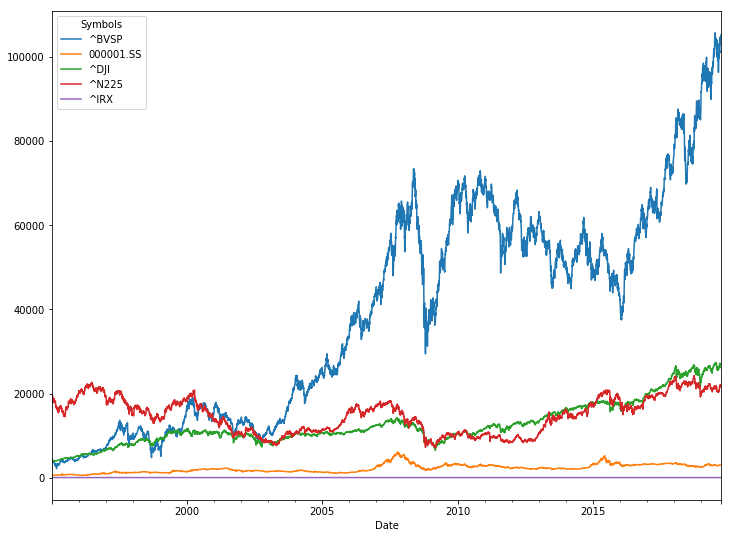

In [7]:
# first inpection: our variables have diffrente levels...
df.plot(figsize=(12,9))
dfo=df #saving the original DataFrame

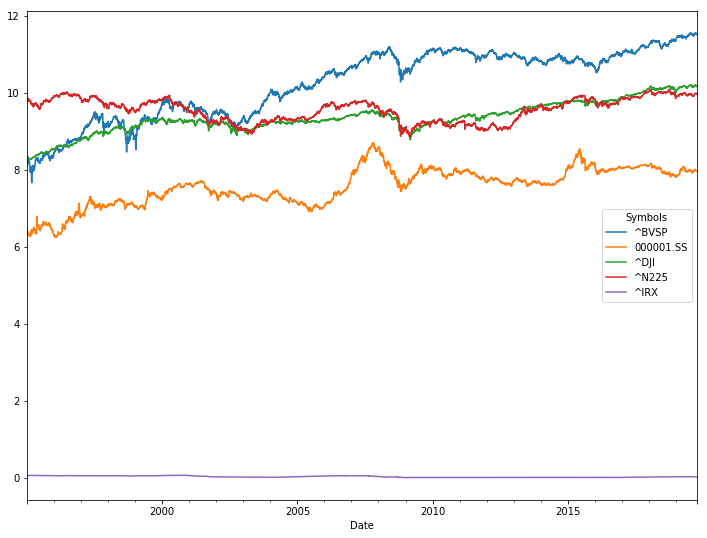

In [8]:
# graf of variables in log: let'us put in log.
# we just can see some comovements 
dfg=np.log(df)
dfg.plot(figsize=(12,9))

In [9]:
# However, we need to calculate our sotck exchange index returns (up/down/remain)
# this is specially related to stationarity in regard to time series data
df =np.log(df)
df=df.dropna(how='any')
df.head()

Symbols,^BVSP,000001.SS,^DJI,^N225,^IRX
Date,,,,,
1995-01-04,8.285992,6.482817,8.257813,9.887563,0.055340
1995-01-05,8.303183,6.472176,8.256067,9.884106,0.055529
1995-01-06,8.249941,6.462655,8.260340,9.879167,0.055813
1995-01-09,8.196382,6.439350,8.258772,9.875341,0.055908
1995-01-10,8.092545,6.413951,8.260167,9.878244,0.055813


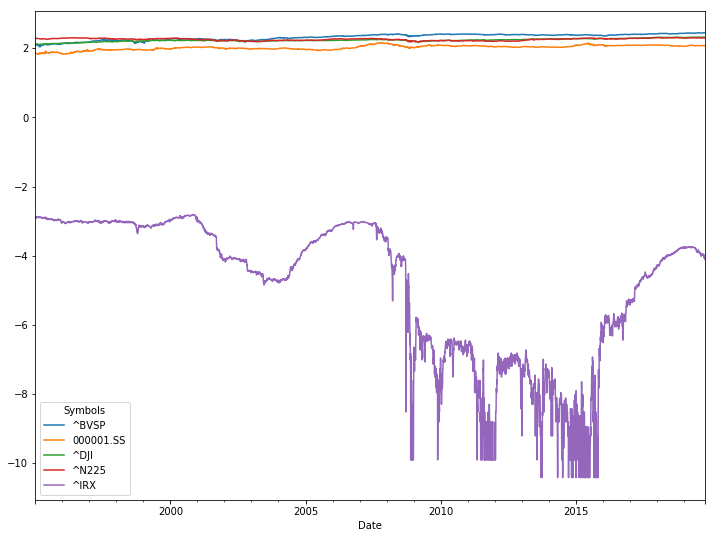

In [10]:
#graph of returns: oscillation 
dfg=np.log(df)
dfg.plot(figsize=(12,9))

In [11]:
#Descriptive Satistics: mean is around almost zero
# as expected in a financial varibles (arbitrage theory)
df.describe()

Symbols,^BVSP,000001.SS,^DJI,^N225,^IRX
count,6458.000000,6458.000000,6458.000000,6458.000000,6458.000000
mean,10.252307,7.569616,9.355709,9.563378,0.022505
std,0.899406,0.489171,0.407590,0.301342,0.020418
min,7.667766,6.246998,8.251163,8.861489,0.000030
25%,9.474107,7.232895,9.140927,9.286086,0.001449
50%,10.622205,7.633181,9.297742,9.632473,0.016759
75%,10.991460,7.971611,9.631425,9.803977,0.046072
max,11.569466,8.714741,10.216807,10.097022,0.060342


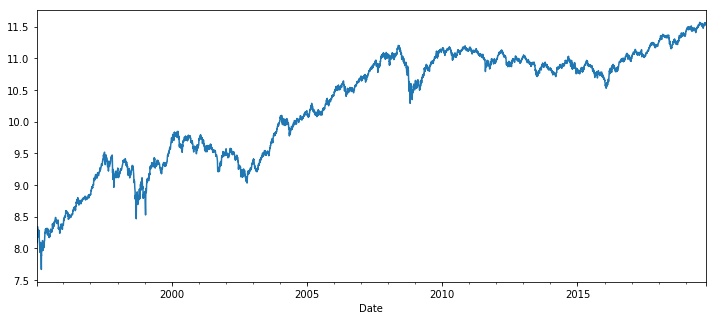

In [12]:
# let'us take a look closely into our target/dependent variable: Brazilian Sotck Exchange Index
# osciliation through time
df['^BVSP'].plot(figsize=(12,5))

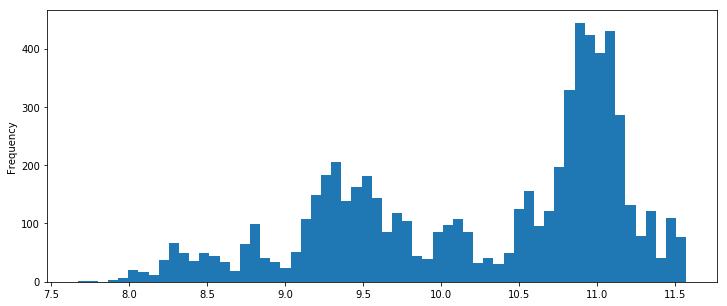

In [13]:
#our target variable histogram: much of the data is around zero, as expected
df['^BVSP'].plot.hist(bins = 60,figsize=(12,5))

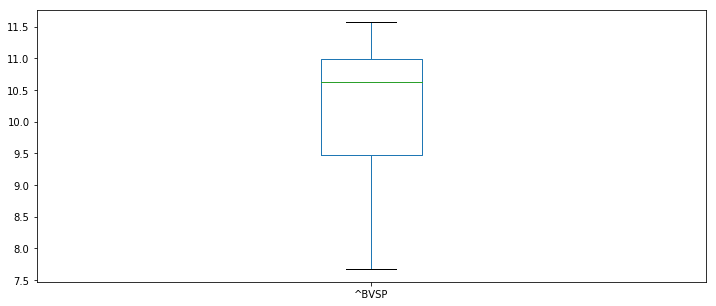

In [14]:
# many outliers: crises! that may come from abroad or due to internal issues
df['^BVSP'].plot.box(figsize=(12,5))

In [15]:
#Correlation matrix: comovements
# EUA/DJI has the biggest correlation with BRA/BVSP
df.corr()

Symbols,^BVSP,000001.SS,^DJI,^N225,^IRX
Symbols,,,,,
^BVSP,1.000000,0.857966,0.830311,-0.054493,-0.670986
000001.SS,0.857966,1.000000,0.774761,-0.017395,-0.578743
^DJI,0.830311,0.774761,1.000000,0.280019,-0.498987
^N225,-0.054493,-0.017395,0.280019,1.000000,0.467852
^IRX,-0.670986,-0.578743,-0.498987,0.467852,1.000000


## Model

We are going to creat an LSTM stateful

In [239]:
# defining the batch size and number of epochs
batch_size = 8
epochs = 120
timesteps = 10
test_percent=.1
print(len(df))

6458


In [240]:
## Scaling data for LSTM
dataset = df
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_features = df.shape[1]

In [241]:
## function in order to create our variables lags
###https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [242]:
##  MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [243]:
reframed = series_to_supervised(scaled, timesteps,1)                                                          
reframed.shape

(6448, 55)

In [244]:
# getting the train and test dataset size

def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            #print(x)
    return (max(train_length_values))

length = get_train_length(reframed, batch_size, test_percent)
upper_train = length + timesteps*2
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            #print(x)
    return (max(test_length_values))


test_length = get_test_length(reframed, batch_size)


print(length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)




5800
600


In [245]:
# split into train and test sets
values = reframed.values
## must starts from the end to the begin (though not all data from the begging will be used, due to batch_size)
train = values[len(reframed)-length-testset_length:-testset_length,:]
test = values[-testset_length:]

# split into input and outputs
n_obs = timesteps * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
#print(train_X.shape, len(train_X), train_y.shape)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], timesteps, n_features))
test_X = test_X.reshape((test_X.shape[0], timesteps, n_features))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


In [246]:
## Stateless 1 layers
modelo = Sequential()
modelo.add(LSTM(55, activation='relu',input_shape=(timesteps,train_X.shape[2])))
modelo.add(Dropout(0.3))
modelo.add(Activation('linear'))
modelo.add(Dense(1))
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
adam = optimizers.adam(lr=0.01)
rmsprop = optimizers.RMSprop(lr=0.01)
modelo.compile(loss = 'mae', optimizer = 'adam')

history = modelo.fit( train_X ,train_y ,validation_split = 0.15
                                                         ,epochs = epochs 
                                                         ,batch_size = batch_size
                                                         ,verbose = 0
                                                         ,shuffle = False)

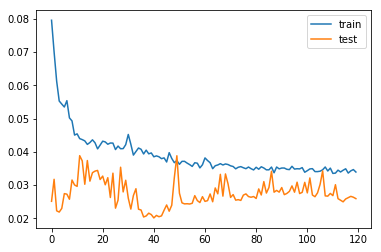

In [247]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [248]:
yhattraino = modelo.predict(train_X)
yhato = modelo.predict(test_X)

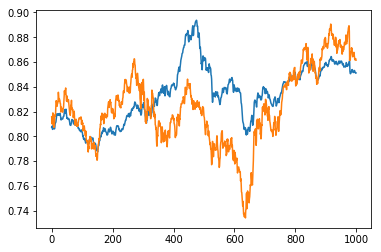

In [249]:
plt.plot(yhattraino[-1000:])
plt.plot(train_y[-1000:])

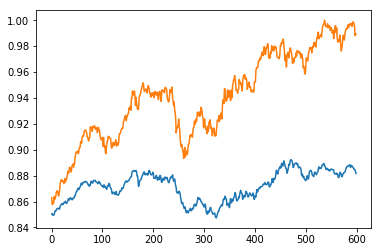

In [250]:
plt.plot(yhato[-1000:])
plt.plot(test_y[-1000:])

In [251]:
mapetrain = mean_absolute_percentage_error(train_y[-4000:],yhattraino[-4000:])
mapetest = mean_absolute_percentage_error(test_y, yhato )
rmsetrain = sqrt(mean_squared_error(train_y, yhattraino))
rmsetest = sqrt(mean_squared_error(test_y, yhato ))

print(mapetrain)
print(mapetest)
print(rmsetrain)
print(rmsetest)

20.893631875514984
7.260413467884064
0.06028208977681397
0.07406713974680385


In [252]:
## Stateful 1 layer
model1 = Sequential()
model1.add(LSTM(55, batch_input_shape=(batch_size,timesteps,train_X.shape[2]),stateful=True))
model1.add(Activation('relu'))
model1.add(Dropout(0.4))
model1.add(Dense(1))
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
adam = optimizers.adam(lr=0.01)
rmsprop = optimizers.RMSprop(lr=0.01)
model1.compile(loss = 'mae', optimizer = 'adam')
# fit network
history = model1.fit( train_X ,train_y ,validation_data = (test_X, test_y)
                         ,epochs = epochs 
                         ,batch_size = batch_size
                         ,verbose = 0
                         ,shuffle = False)# plot history
model1.reset_states()

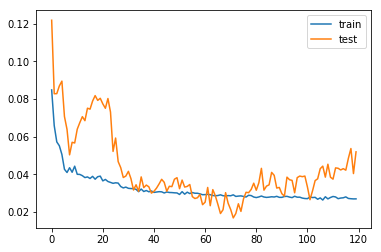

In [253]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [254]:
yhattrain1 = model1.predict(train_X,batch_size=batch_size,verbose=0)
yhat1 = model1.predict(test_X,batch_size=batch_size,verbose=0)



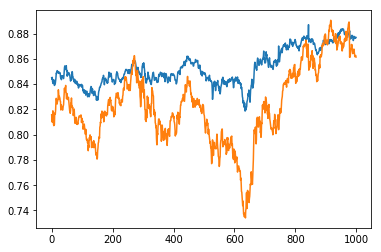

In [255]:
plt.plot(yhattrain1[-1000:])
plt.plot(train_y[-1000:])

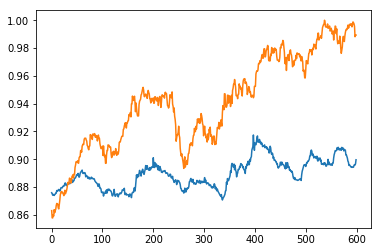

In [256]:
plt.plot(yhat1[-1000:])
plt.plot(test_y[-1000:])

In [257]:
mapetrain = mean_absolute_percentage_error(train_y[-4000:],yhattrain1[-4000:])
mapetest = mean_absolute_percentage_error(test_y, yhat1 )
rmsetrain = sqrt(mean_squared_error(train_y, yhattrain1))
rmsetest = sqrt(mean_squared_error(test_y, yhat1 ))

print(mapetrain)
print(mapetest)
print(rmsetrain)
print(rmsetest)

22.316549718379974
5.601440370082855
0.049926650553170714
0.05819164025202741


In [258]:
test_X1 = test_X.reshape((test_X.shape[0], timesteps*n_features))
# invert scaling for forecast
inv_yhat1 = np.concatenate((yhat1, test_X1[:, -(len(df.columns)-1):]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]
nyhat1=np.exp(inv_yhat1)

In [259]:
# invert scaling for actual
test_y1 = test_y.reshape((len(test_y), 1))
inv_y1 = np.concatenate((test_y1, test_X1[:, -(len(df.columns)-1):]), axis=1)
inv_y1 = scaler.inverse_transform(inv_y1)
inv_y1 = inv_y1[:,0]
nytest1=np.exp(inv_y1)

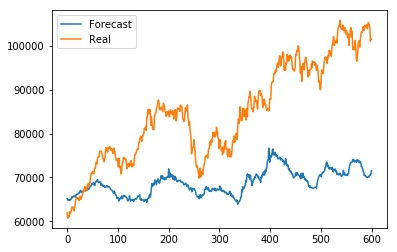

In [260]:
plt.plot(nyhat1[-1000:],label='Forecast')
plt.plot(nytest1[-1000:],label='Real')
plt.legend()
plt.show()

In [134]:
print('Forecast call for today',nyhat1[-1:][0])

Forecast call for today 103304.86


In [135]:
d=(sum((nyhat1-nytest1)**2)**0.5)/len(nytest1)

In [136]:
nyhat1[-1:][0]+5*d

104481.01583887273

In [137]:
dfo.tail()

Symbols,^BVSP,000001.SS,^DJI,^N225,^IRX
Date,,,,,
2019-09-30,104745.0,2905.189941,26916.830078,21755.839844,1.01770
2019-10-01,104053.0,2905.189941,26573.039062,21885.240234,1.01753
2019-10-02,101031.0,2905.189941,26078.619141,21778.609375,1.01735
2019-10-03,101516.0,2905.189941,26201.039062,21341.740234,1.01665
2019-10-04,101516.0,2905.189941,26201.039062,21410.199219,1.01665


In [75]:
c=sum((nyhat1-nytest1)**2)**0.5
c

191388.52447854428